import libraries and read data

In [43]:
# we have to install the development version for the time being
#!pip uninstall eodal -y
#!pip install git+https://github.com/lukasValentin/eodal@landsat-dev

In [44]:
# Import general libraries
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np

from shapely.geometry import Point
from sklearn.mixture import GaussianMixture
from sklearn.mixture import GaussianMixture

# Import scikit-learn libraries
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from sklearn.metrics import pairwise_distances
from sklearn.cluster import MeanShift
from sklearn.preprocessing import StandardScaler
print("Version of scikit-learn: " + sklearn.__version__)

# Import EOdal libraries
import eodal
from eodal.core.band import Band
from eodal.core.raster import RasterCollection

# Print EOdal version
print("Version of EOdal: " + eodal.__version__)

Version of scikit-learn: 1.2.1
Version of EOdal: 0.2.1


In [45]:
year = 2021

In [46]:
#read tif from disk:
#fpath_raster = Path(f'S:\MSc_23_TimckeFinn\data\EOdal\landsat_median_composite_{year}.tif')
fpath_raster = Path(f'S:\MSc_23_TimckeFinn\data\EOdal\landsat_median_composite_2021_smallAOI.tif')

# initialize a RasterCollection from the .tif file
composite = RasterCollection.from_multi_band_raster(fpath_raster=fpath_raster, 
                                                    band_aliases = ["blue", "green", "red", "nir_1", "swir_1","swir_2"])
composite.band_summaries()


,min,mean,std,max,count,geometry,band_name
0,0.07760,0.081771,0.001599,0.092600,4814.0,"POLYGON ((872055.000 53175.000, 872055.000 549...",blue_median
1,0.08410,0.092296,0.002920,0.109155,4814.0,"POLYGON ((872055.000 53175.000, 872055.000 549...",green_median
2,0.07994,0.086842,0.003234,0.109370,4814.0,"POLYGON ((872055.000 53175.000, 872055.000 549...",red_median
3,0.08990,0.183595,0.021899,0.231075,4814.0,"POLYGON ((872055.000 53175.000, 872055.000 549...",nir08_median
4,0.07854,0.130438,0.013279,0.165970,4814.0,"POLYGON ((872055.000 53175.000, 872055.000 549...",swir16_median
5,0.07589,0.100523,0.007958,0.132895,4814.0,"POLYGON ((872055.000 53175.000, 872055.000 549...",swir22_median


## Feature extraction

In [47]:
# calculate some SI
composite.calc_si('NDVI', inplace = True)
composite.calc_si('NDWI', inplace = True)
composite.calc_si('EVI', inplace = True)
composite.calc_si('CI_GREEN', inplace = True)
composite.calc_si('MSAVI', inplace = True)
composite.calc_si('BSI', inplace = True)

# print band summaries
composite.band_summaries()

,min,mean,std,max,count,geometry,band_name
0,0.077600,0.081771,0.001599,0.092600,4814.0,"POLYGON ((872055.000 53175.000, 872055.000 549...",blue_median
1,0.084100,0.092296,0.002920,0.109155,4814.0,"POLYGON ((872055.000 53175.000, 872055.000 549...",green_median
2,0.079940,0.086842,0.003234,0.109370,4814.0,"POLYGON ((872055.000 53175.000, 872055.000 549...",red_median
3,0.089900,0.183595,0.021899,0.231075,4814.0,"POLYGON ((872055.000 53175.000, 872055.000 549...",nir08_median
4,0.078540,0.130438,0.013279,0.165970,4814.0,"POLYGON ((872055.000 53175.000, 872055.000 549...",swir16_median
5,0.075890,0.100523,0.007958,0.132895,4814.0,"POLYGON ((872055.000 53175.000, 872055.000 549...",swir22_median
6,0.023488,0.352437,0.070284,0.458988,4814.0,"POLYGON ((872055.000 53175.000, 872055.000 549...",NDVI
7,-0.421026,-0.325719,0.067669,0.000723,4814.0,"POLYGON ((872055.000 53175.000, 872055.000 549...",NDWI
8,0.010375,0.220746,0.049319,0.319509,4814.0,"POLYGON ((872055.000 53175.000, 872055.000 549...",EVI
9,-0.001444,0.989403,0.235520,1.454389,4814.0,"POLYGON ((872055.000 53175.000, 872055.000 549...",CI_GREEN


Text(0.5, 1.0, 'Agriculture')

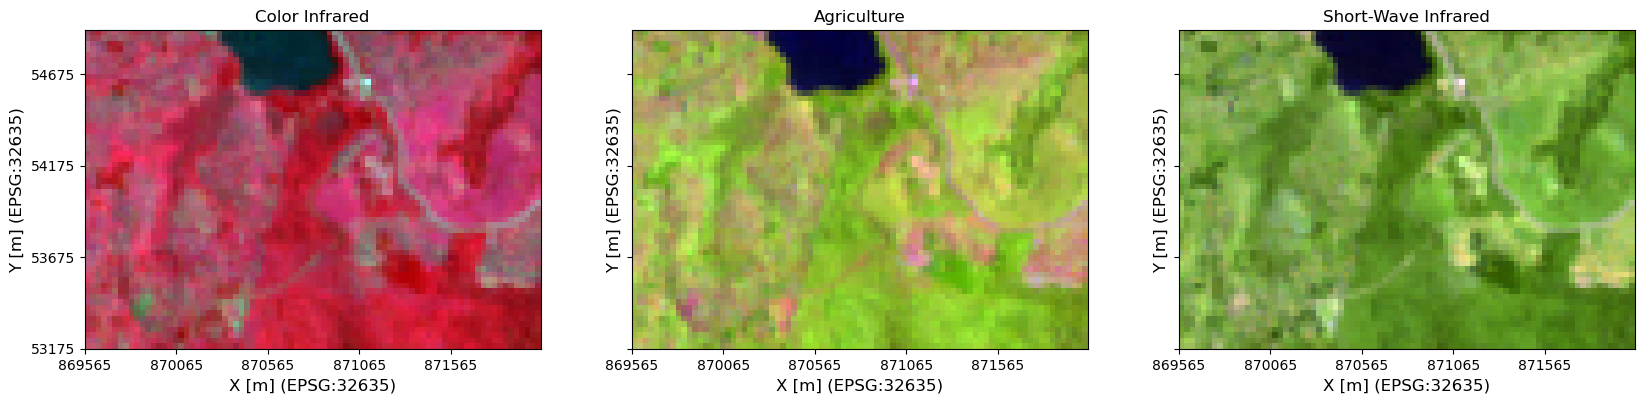

In [48]:
#plot band combinations
fig, axs = plt.subplots(1, 3, figsize = (20, 10), sharey=True)

composite.plot_multiple_bands(["swir22_median", "swir16_median", "red_median"], ax=axs[2])
axs[2].set_title("Short-Wave Infrared")
# The short-wave infrared band combination uses SWIR-2 (7), SWIR-1 (6), and red (4). This composite displays vegetation in shades of green. While darker shades of green indicate denser vegetation, sparse vegetation has lighter shades. Urban areas are blue and soils have various shades of brown.

composite.plot_multiple_bands(["nir08_median", "red_median", "green_median"], ax=axs[0])
axs[0].set_title("Color Infrared")
# This band combination is also called the near-infrared (NIR) composite. It uses near-infrared (5), red (4), and green (3). Because chlorophyll reflects near-infrared light, this band composition is useful for analyzing vegetation. In particular, areas in red have better vegetation health. Dark areas are water and urban areas are white.

composite.plot_multiple_bands(["swir16_median", "nir08_median", "blue_median"], ax=axs[1])
axs[1].set_title("Agriculture")
# This band combination uses SWIR-1 (6), near-infrared (5), and blue (2). It’s commonly used for crop monitoring because of the use of short-wave and near-infrared. Healthy vegetation appears dark green. But bare earth has a magenta hue.


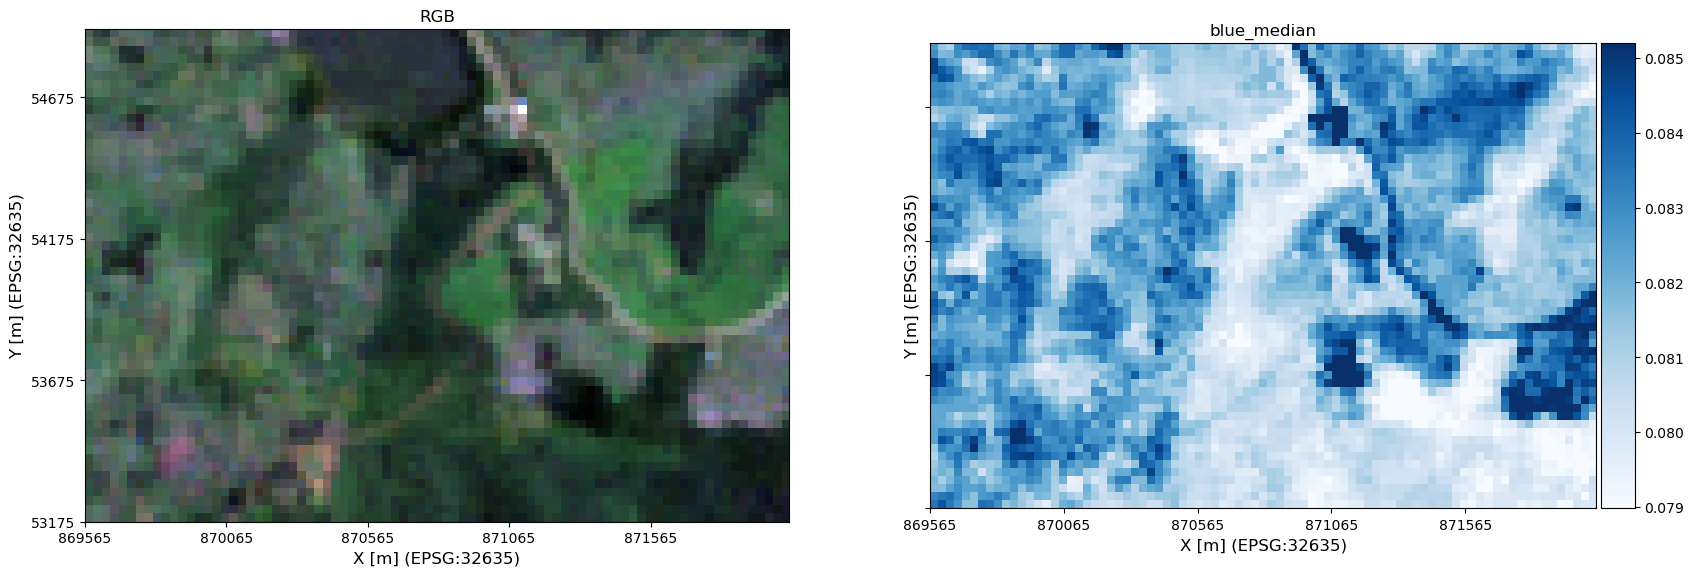

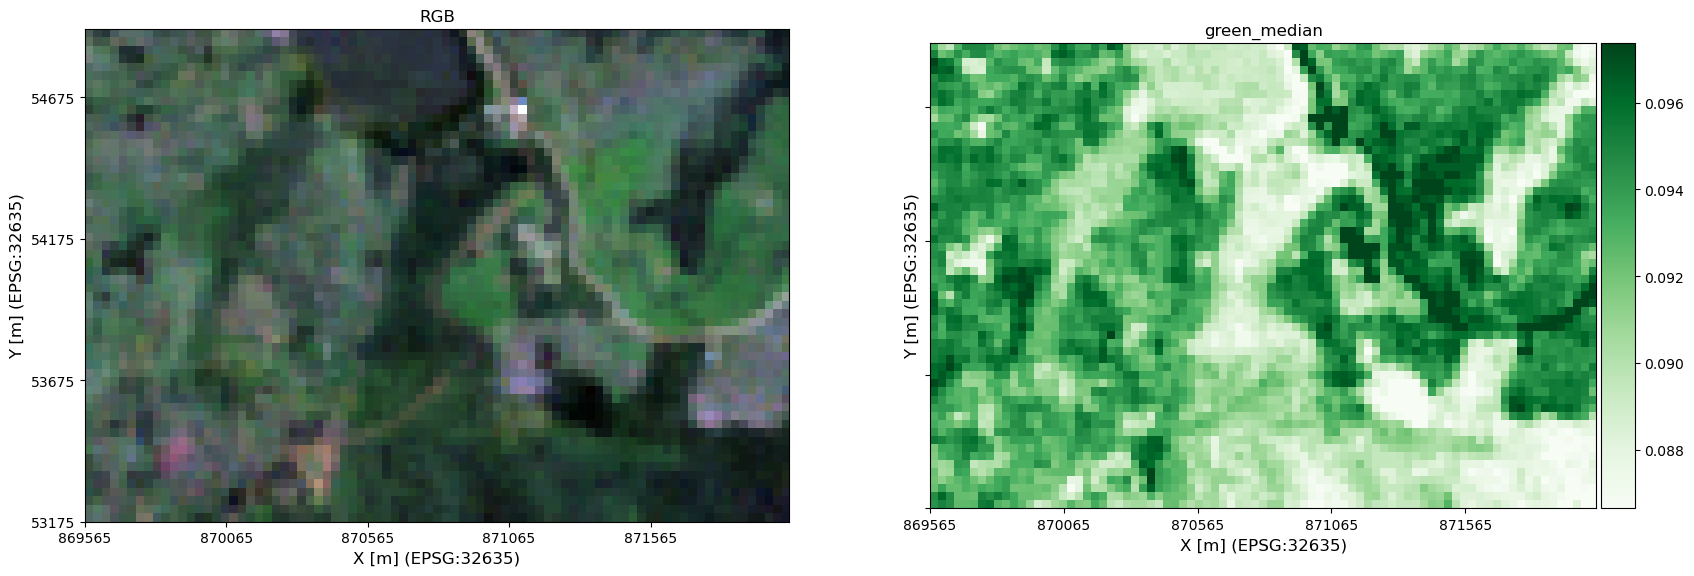

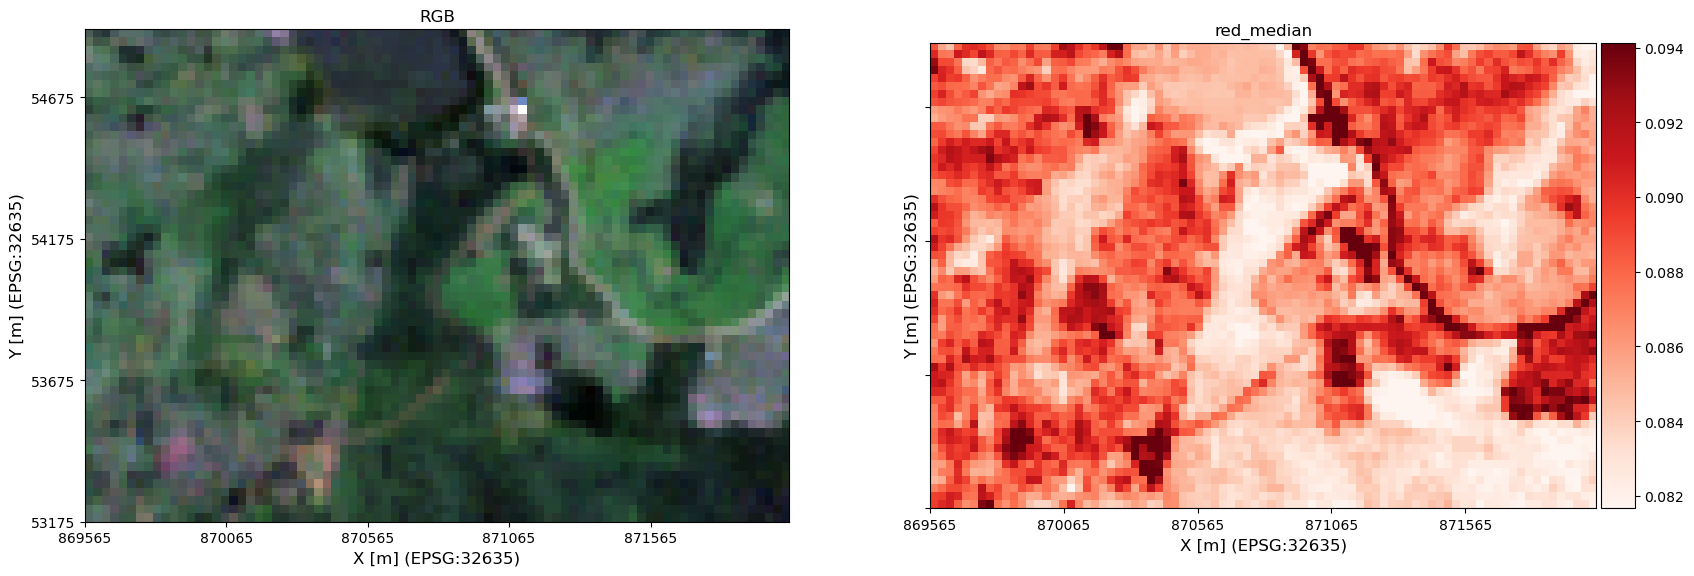

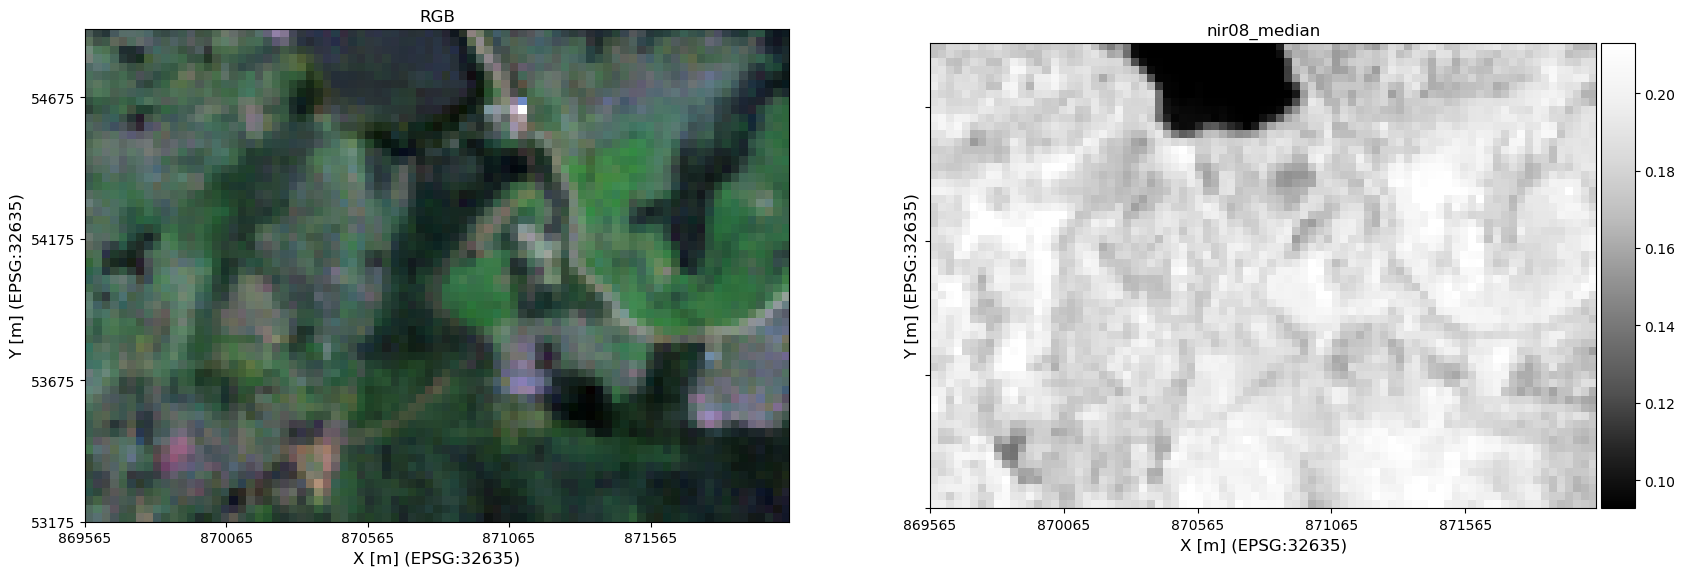

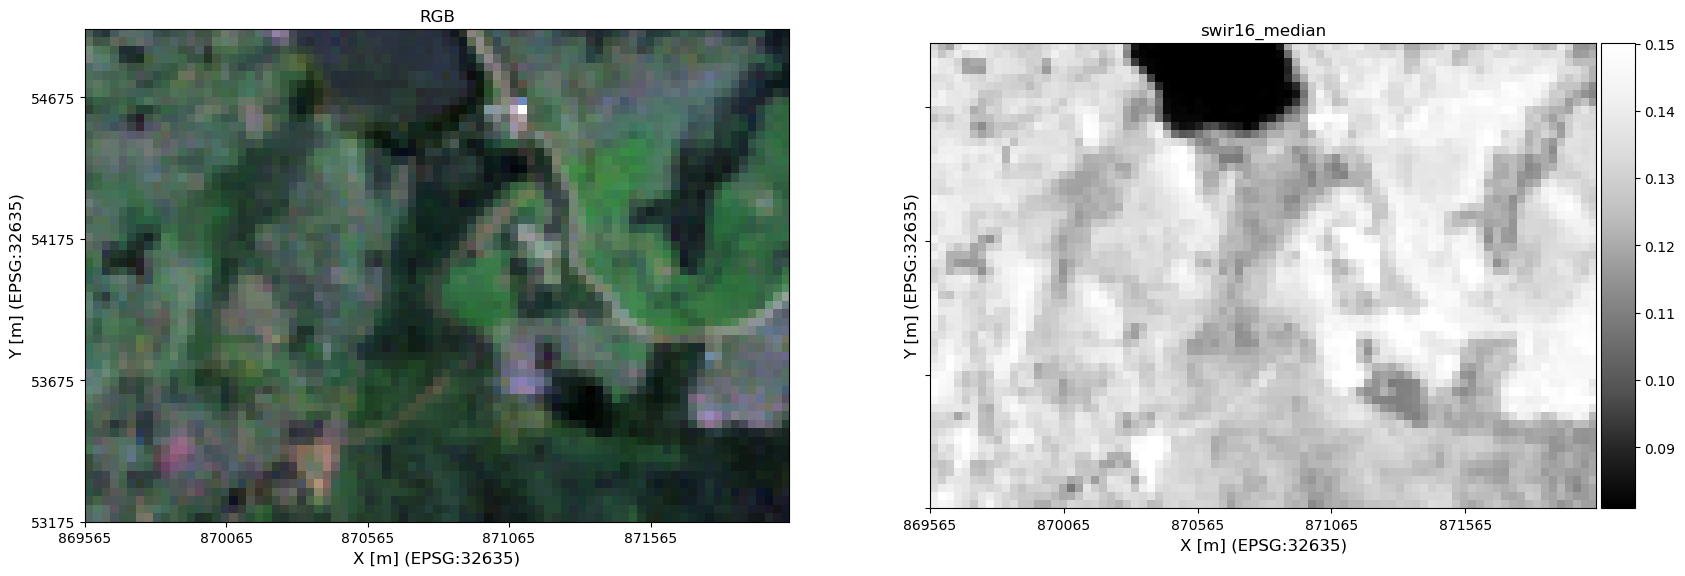

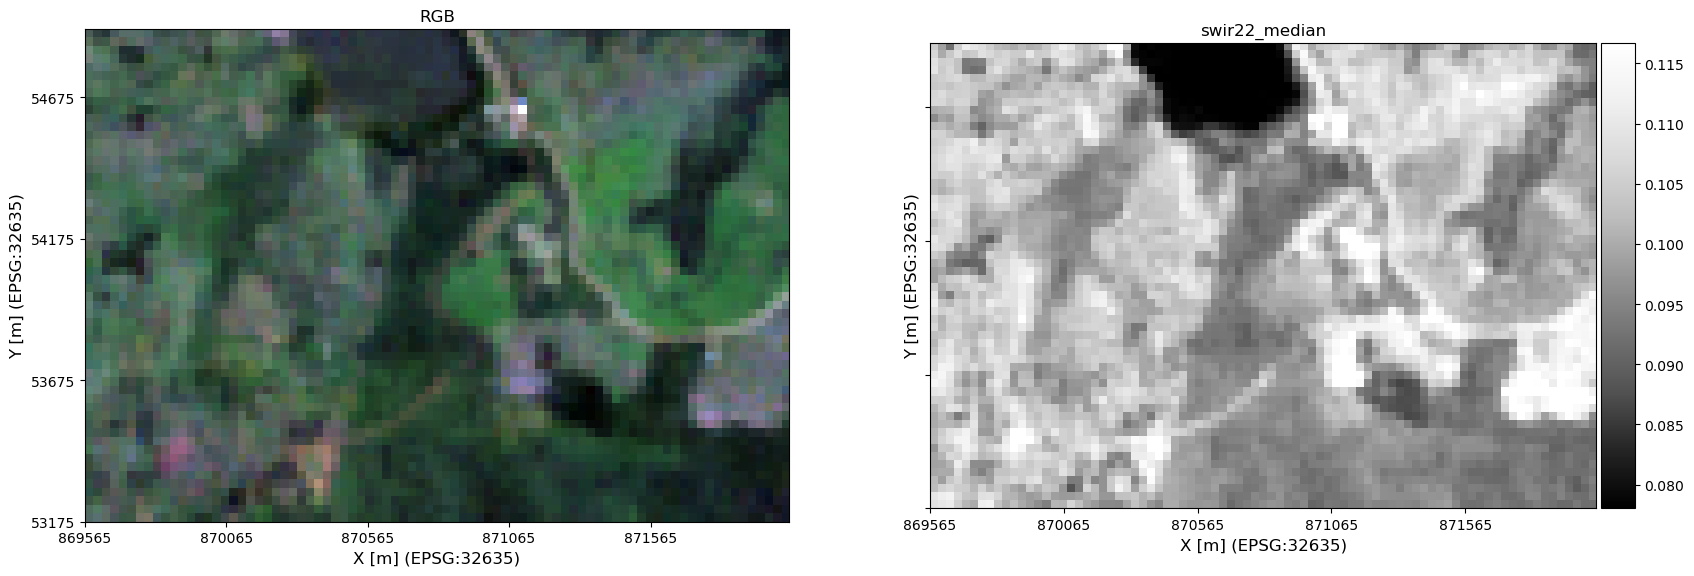

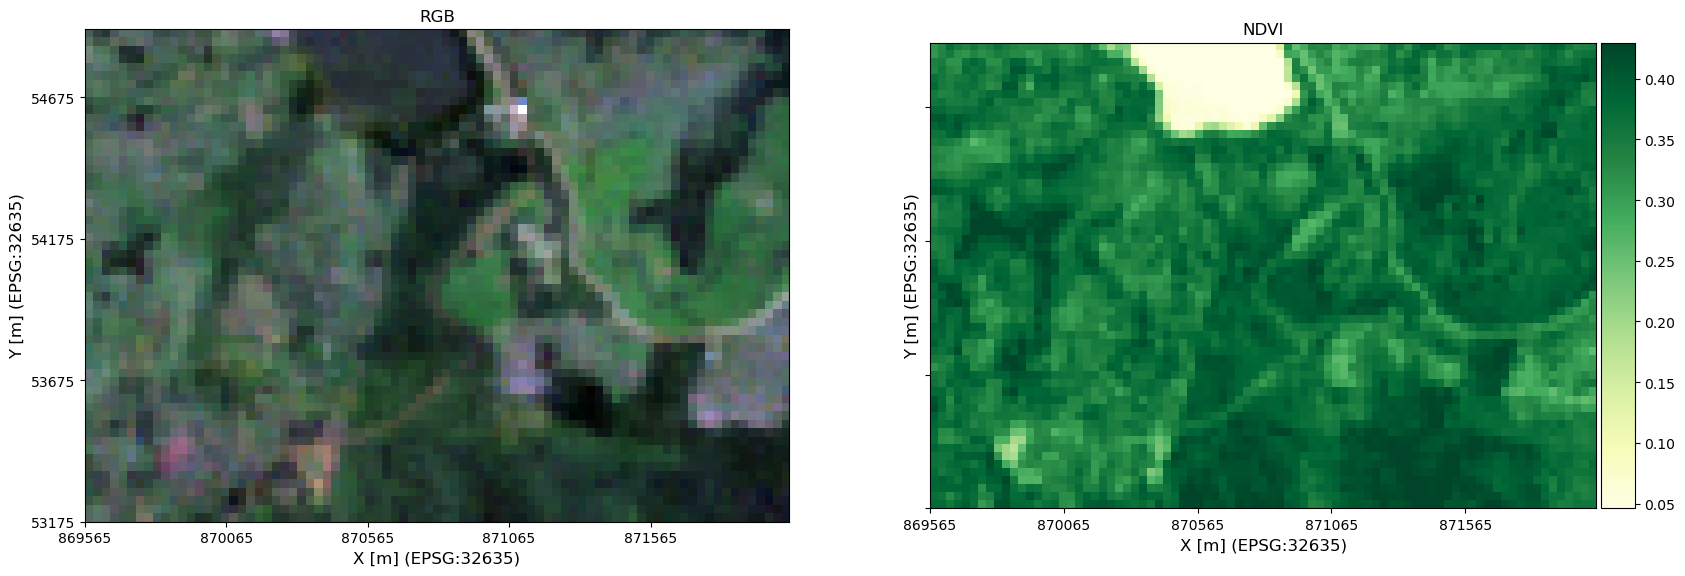

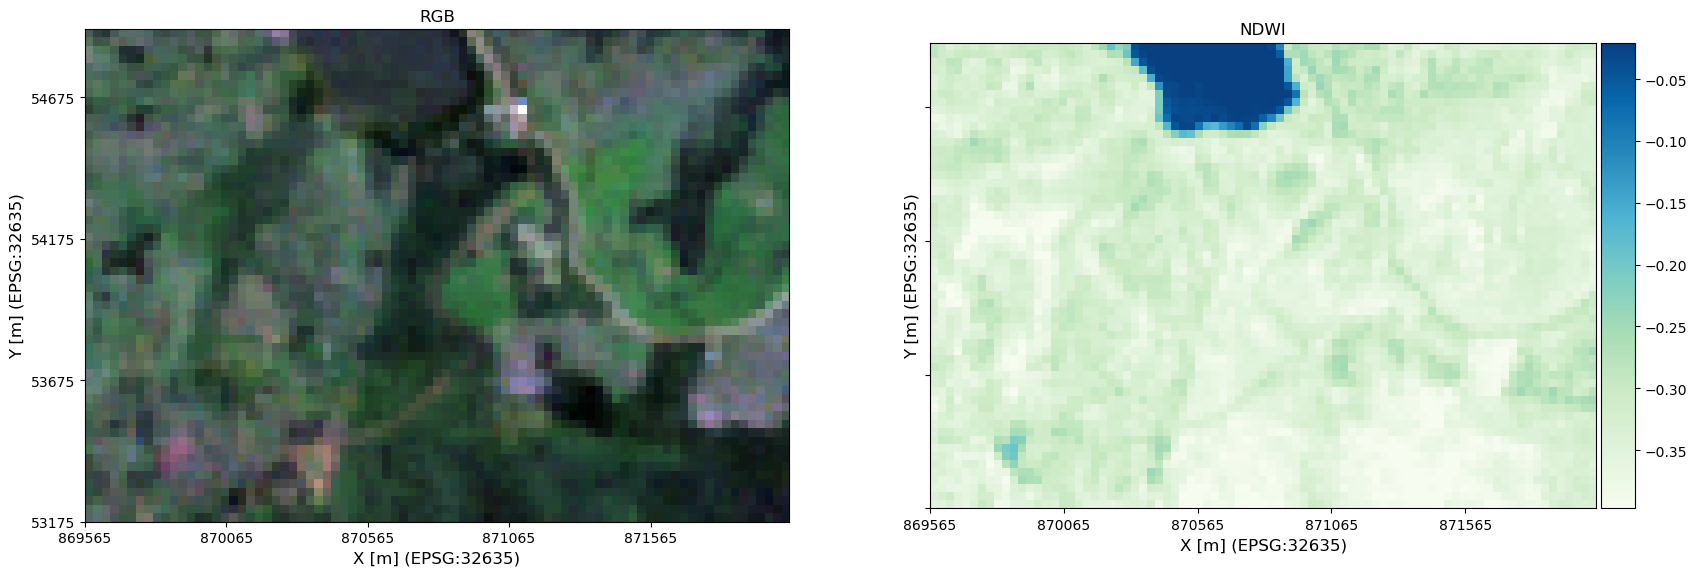

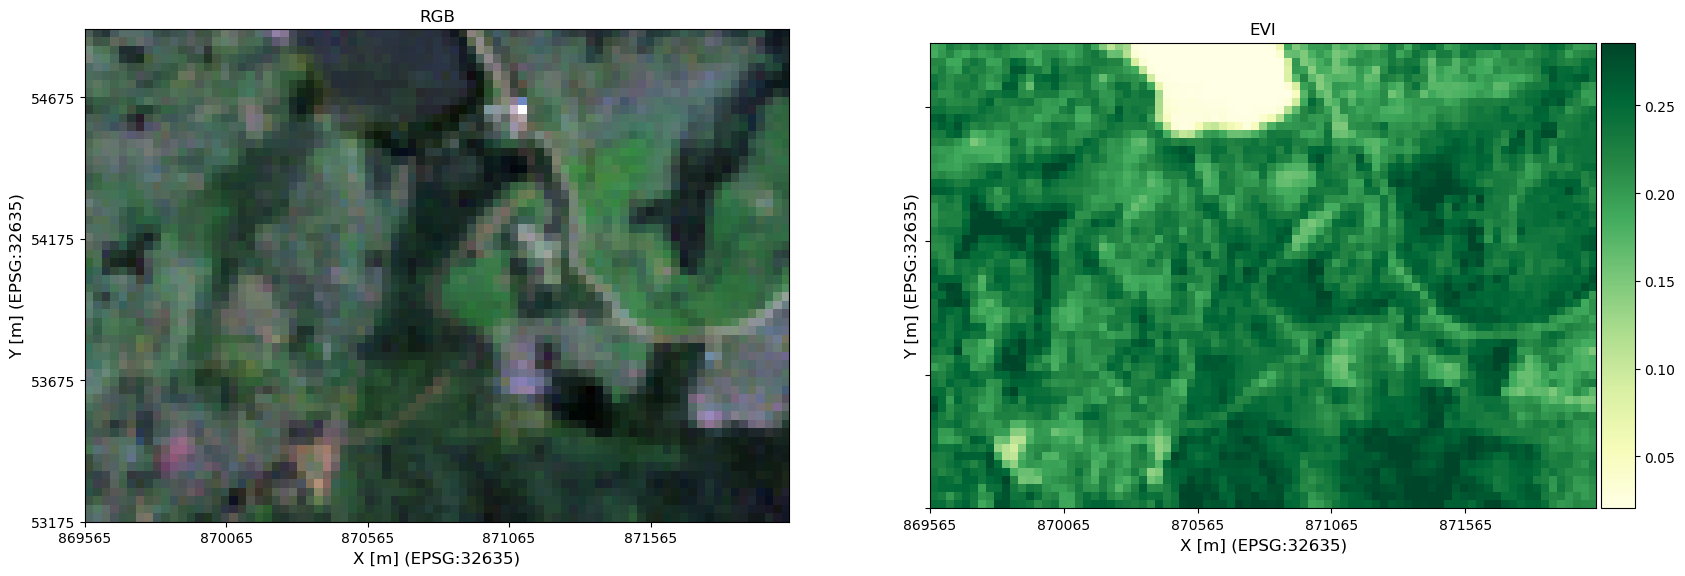

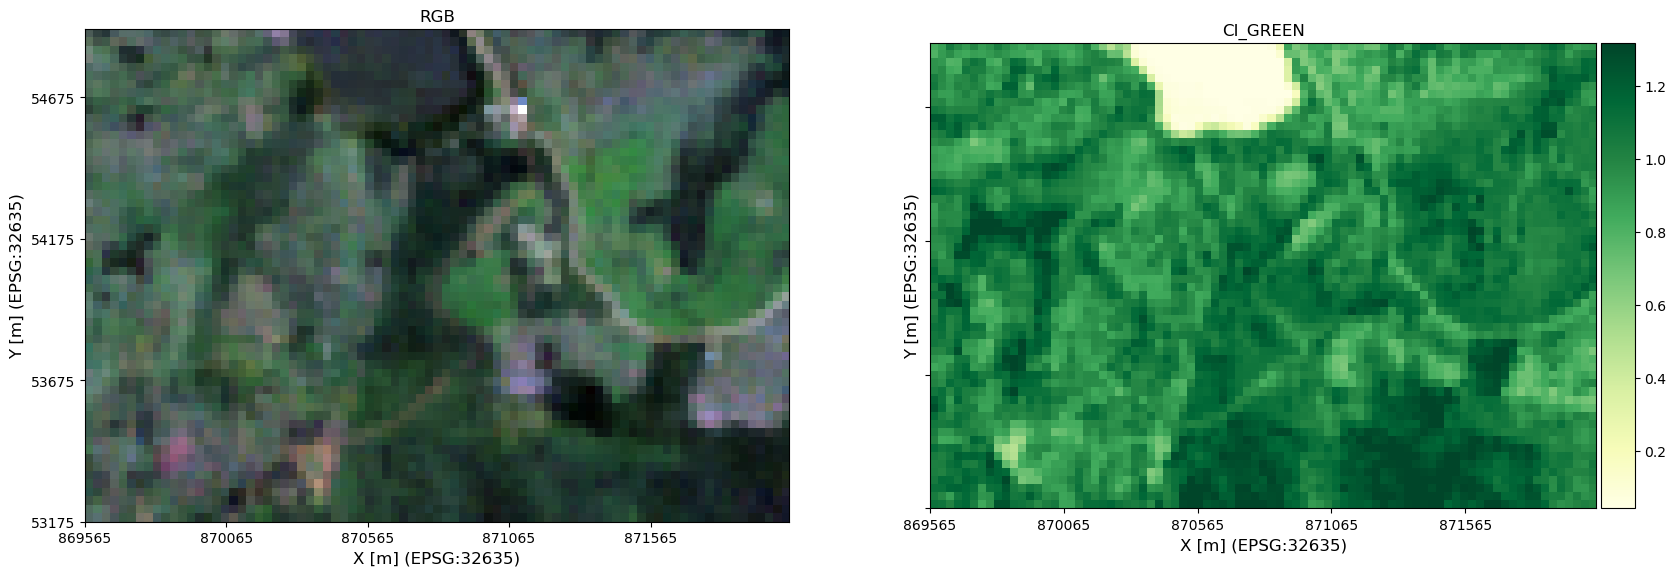

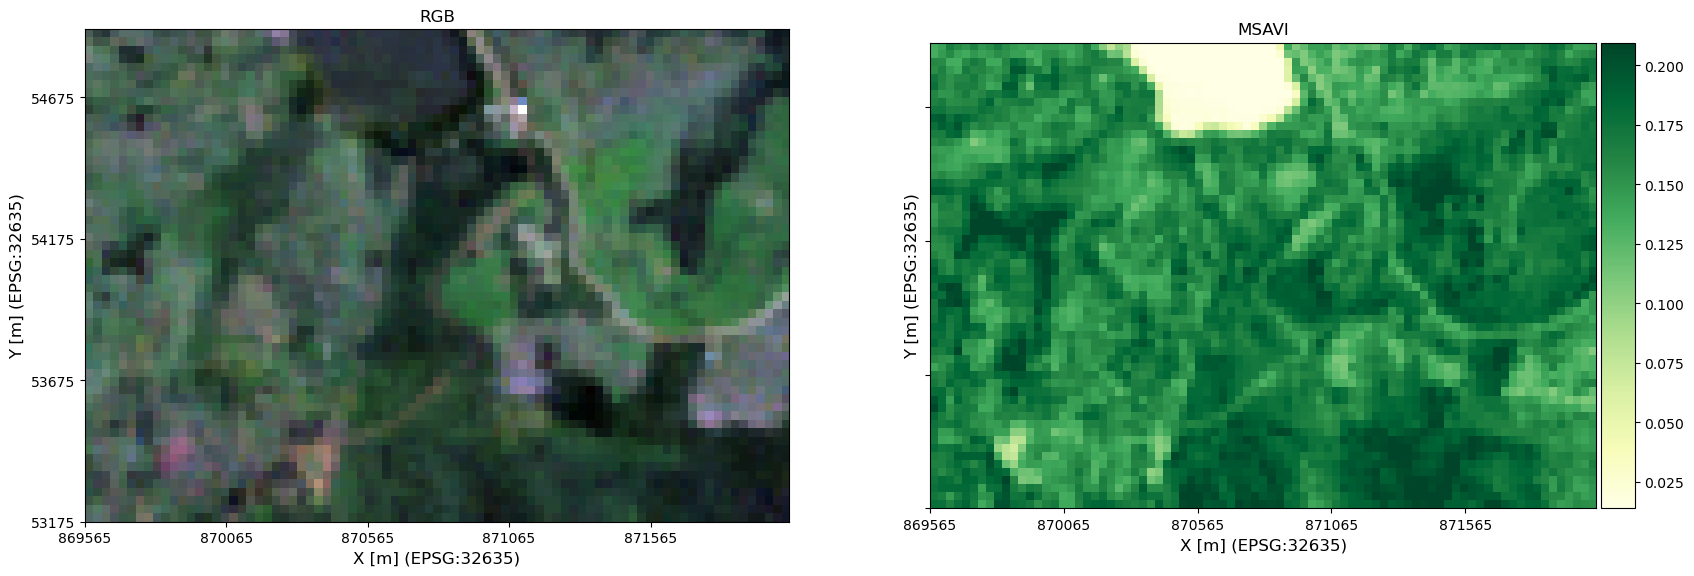

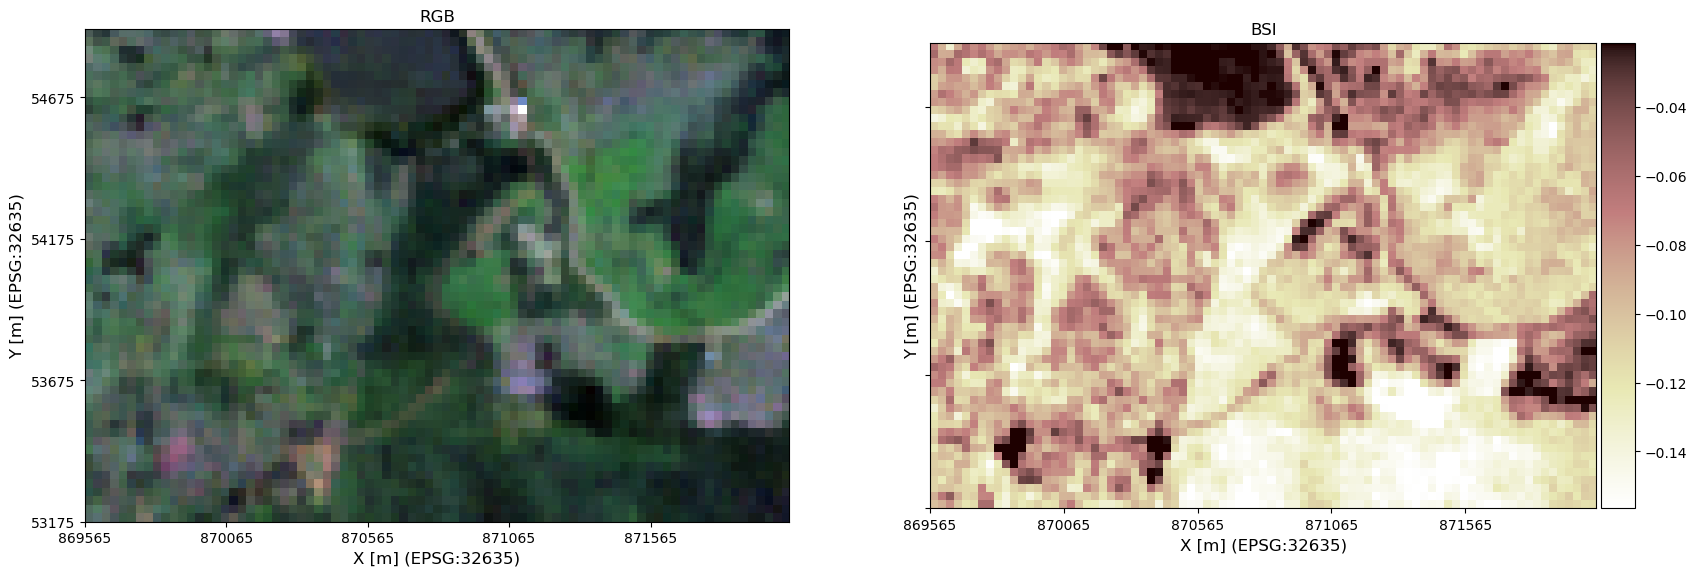

In [49]:
#plot individual bands:
for band in composite.band_names:
    fig, axs = plt.subplots(1, 2, figsize = (20, 10), sharey=True)
    composite.plot_multiple_bands(["red", "green", "blue"], ax=axs[0])
    axs[0].set_title("RGB")
    if band == 'blue_median':
        composite.plot_band(band, colormap="Blues", ax=axs[1])
        axs[1].set_title(band)
    if band == 'green_median':
        composite.plot_band(band, colormap="Greens", ax=axs[1])
        axs[1].set_title(band)
    if band == 'red_median':
        composite.plot_band(band, colormap="Reds", ax=axs[1])
        axs[1].set_title(band)
    if band == 'nir08_median':
        composite.plot_band(band, colormap="Greys_r", ax=axs[1])
        axs[1].set_title(band)
    if band == 'swir16_median':
        composite.plot_band(band, colormap="Greys_r", ax=axs[1])
        axs[1].set_title(band)
    if band == 'swir22_median':
        composite.plot_band(band, colormap="Greys_r", ax=axs[1])
        axs[1].set_title(band)
    if band == 'NDVI':
        composite.plot_band(band, colormap="YlGn", ax=axs[1])
        axs[1].set_title(band)
    if band == 'NDWI':
        composite.plot_band(band, colormap="GnBu", ax=axs[1])
        axs[1].set_title(band)
    if band == 'EVI':
        composite.plot_band(band, colormap="YlGn", ax=axs[1])
        axs[1].set_title(band)
    if band == 'CI_GREEN':
        composite.plot_band(band, colormap="YlGn", ax=axs[1])
        axs[1].set_title(band)
    if band == 'MSAVI':
        composite.plot_band(band, colormap="YlGn", ax=axs[1])
        axs[1].set_title(band)
    if band == 'BSI':
        composite.plot_band(band, colormap="pink_r", ax=axs[1])
        axs[1].set_title(band)


In [50]:
# Create a DataFrame from the RasterCollection
gdf = composite.to_dataframe()

# # Extract x and y coordinates into new columns
# gdf['x_coordinate'] = gdf['geometry'].apply(lambda point: Point(point).x)
# gdf['y_coordinate'] = gdf['geometry'].apply(lambda point: Point(point).y)

# Select all columns for feature space
selected_columns = ['blue_median', 'green_median', 'red_median', 'nir08_median','swir16_median', 'swir22_median', 'NDVI', 'NDWI', 'EVI', 'CI_GREEN', 'MSAVI', 'BSI']

gdf[selected_columns].head()

,blue_median,green_median,red_median,nir08_median,swir16_median,swir22_median,NDVI,NDWI,EVI,CI_GREEN,MSAVI,BSI
0,0.082675,0.09311,0.088645,0.169610,0.132185,0.105060,0.313508,-0.291185,0.187173,0.821609,0.134402,-0.066485
1,0.082930,0.09510,0.090250,0.170940,0.136010,0.106770,0.308932,-0.285070,0.184990,0.797476,0.133557,-0.057505
2,0.084735,0.09747,0.092850,0.188935,0.142200,0.108955,0.340987,-0.319355,0.216306,0.938391,0.157464,-0.075916
3,0.084720,0.09668,0.093625,0.187625,0.139840,0.109515,0.334222,-0.319885,0.210956,0.940681,0.153932,-0.076867
4,0.083560,0.09458,0.089265,0.193275,0.134585,0.104685,0.368125,-0.342864,0.235922,1.043508,0.171154,-0.105825


In [51]:
from sklearn.preprocessing import MinMaxScaler

## Step 1: Extract the feature columns from the GeoDataFrame into a NumPy array
features = gdf[selected_columns].values

## Step 2: Initialize the MinMaxScaler
scaler = MinMaxScaler()

## Step 3: Fit the scaler to the feature data
scaler.fit(features)

## Step 4: Transform the feature data using the fitted scaler
scaled_features = scaler.transform(features)

## Step 5: Replace the original feature values in the GeoDataFrame with the scaled values
gdf[selected_columns] = scaled_features

gdf[selected_columns].head()


,blue_median,green_median,red_median,nir08_median,swir16_median,swir22_median,NDVI,NDWI,EVI,CI_GREEN,MSAVI,BSI
0,0.338333,0.359609,0.295787,0.564618,0.613577,0.511709,0.665947,0.307865,0.571914,0.565348,0.556332,0.526344
1,0.355333,0.439034,0.350323,0.574039,0.657326,0.541707,0.655440,0.322364,0.564851,0.548772,0.552641,0.569870
2,0.475667,0.533626,0.438668,0.701505,0.728125,0.580037,0.729044,0.241070,0.666153,0.645565,0.657083,0.480629
3,0.474667,0.502095,0.465002,0.692226,0.701132,0.589861,0.713511,0.239814,0.648848,0.647138,0.641653,0.476021
4,0.397333,0.418280,0.316854,0.732247,0.641027,0.505131,0.791359,0.185330,0.729608,0.717769,0.716891,0.335654


In [52]:
#show feature space
scaled_features

array([[0.33833333, 0.35960886, 0.29578661, ..., 0.56534825, 0.55633243,
        0.52634406],
       [0.35533333, 0.43903412, 0.3503228 , ..., 0.54877182, 0.5526407 ,
        0.56987027],
       [0.47566667, 0.53362602, 0.43866803, ..., 0.64556516, 0.65708297,
        0.48062934],
       ...,
       [0.17      , 0.10177609, 0.10295617, ..., 0.67797467, 0.6204827 ,
        0.31814583],
       [0.161     , 0.09419278, 0.07509344, ..., 0.66619486, 0.61409753,
        0.32530677],
       [0.15366667, 0.08820595, 0.06761808, ..., 0.68828159, 0.63359981,
        0.2820475 ]])

In [53]:
# Get the colors from the "Accent" colormap
cmap = plt.get_cmap('Accent')
colors = cmap.colors

values = np.arange(8)


c:\Users\ftimcke\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=19.
  warnings.warn(


kmeans, 3, Silhouette score, 0.4130772372308799
kmeans, 3, Calinski-Harabasz score, 6238.024497065896
kmeans, 3, Davies-Bouldin score, 0.7175371127783685


c:\Users\ftimcke\AppData\Local\anaconda3\lib\site-packages\eodal\core\band.py:1637: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.set_ticklabels(user_defined_ticks)
c:\Users\ftimcke\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=19.
  warnings.warn(


kmeans, 4, Silhouette score, 0.34770903228356603
kmeans, 4, Calinski-Harabasz score, 6019.212513714885
kmeans, 4, Davies-Bouldin score, 0.8449514827193838


c:\Users\ftimcke\AppData\Local\anaconda3\lib\site-packages\eodal\core\band.py:1637: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.set_ticklabels(user_defined_ticks)
c:\Users\ftimcke\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=19.
  warnings.warn(


kmeans, 5, Silhouette score, 0.35165232082028636
kmeans, 5, Calinski-Harabasz score, 6041.552841942207
kmeans, 5, Davies-Bouldin score, 0.8071521996188988


c:\Users\ftimcke\AppData\Local\anaconda3\lib\site-packages\eodal\core\band.py:1637: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.set_ticklabels(user_defined_ticks)
c:\Users\ftimcke\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=19.
  warnings.warn(


kmeans, 6, Silhouette score, 0.33052770837029016
kmeans, 6, Calinski-Harabasz score, 5885.090388722926
kmeans, 6, Davies-Bouldin score, 0.8801993873855406


c:\Users\ftimcke\AppData\Local\anaconda3\lib\site-packages\eodal\core\band.py:1637: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.set_ticklabels(user_defined_ticks)
c:\Users\ftimcke\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=19.
  warnings.warn(


kmeans, 7, Silhouette score, 0.3214744905934533
kmeans, 7, Calinski-Harabasz score, 5627.070201127128
kmeans, 7, Davies-Bouldin score, 0.8828659142275785


c:\Users\ftimcke\AppData\Local\anaconda3\lib\site-packages\eodal\core\band.py:1637: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.set_ticklabels(user_defined_ticks)


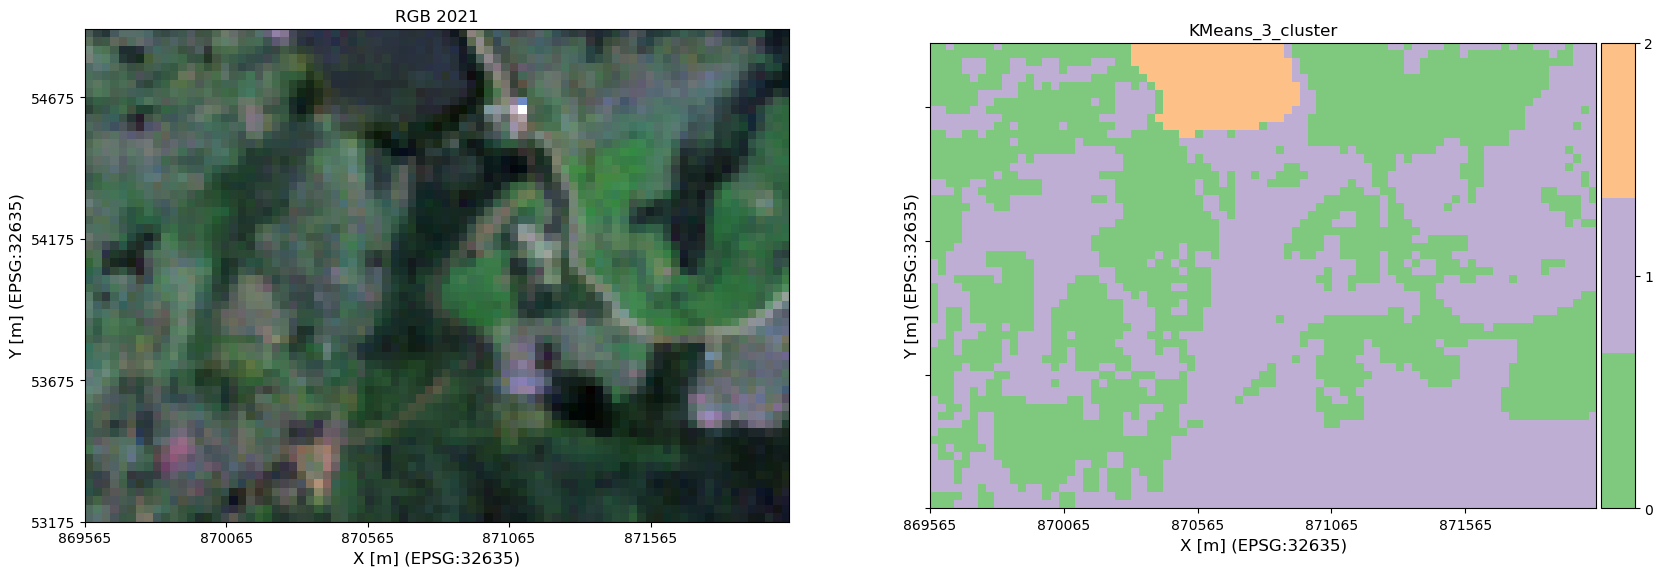

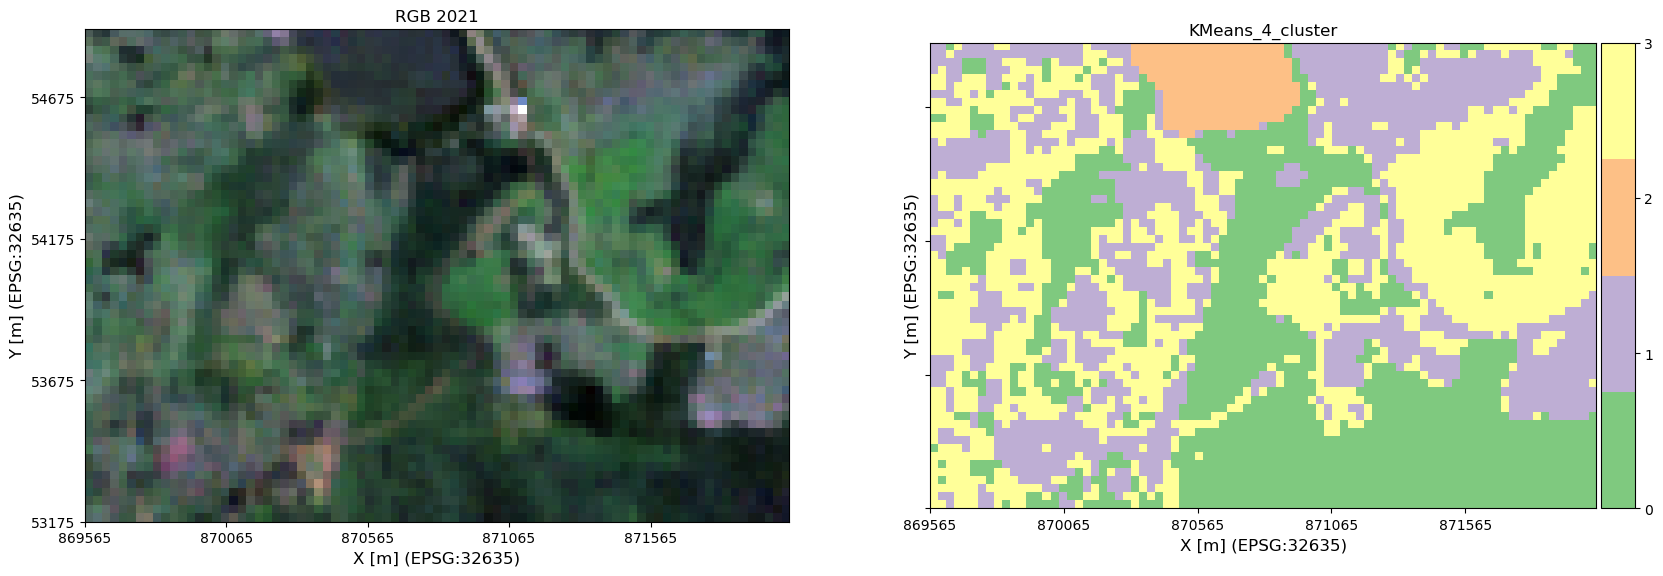

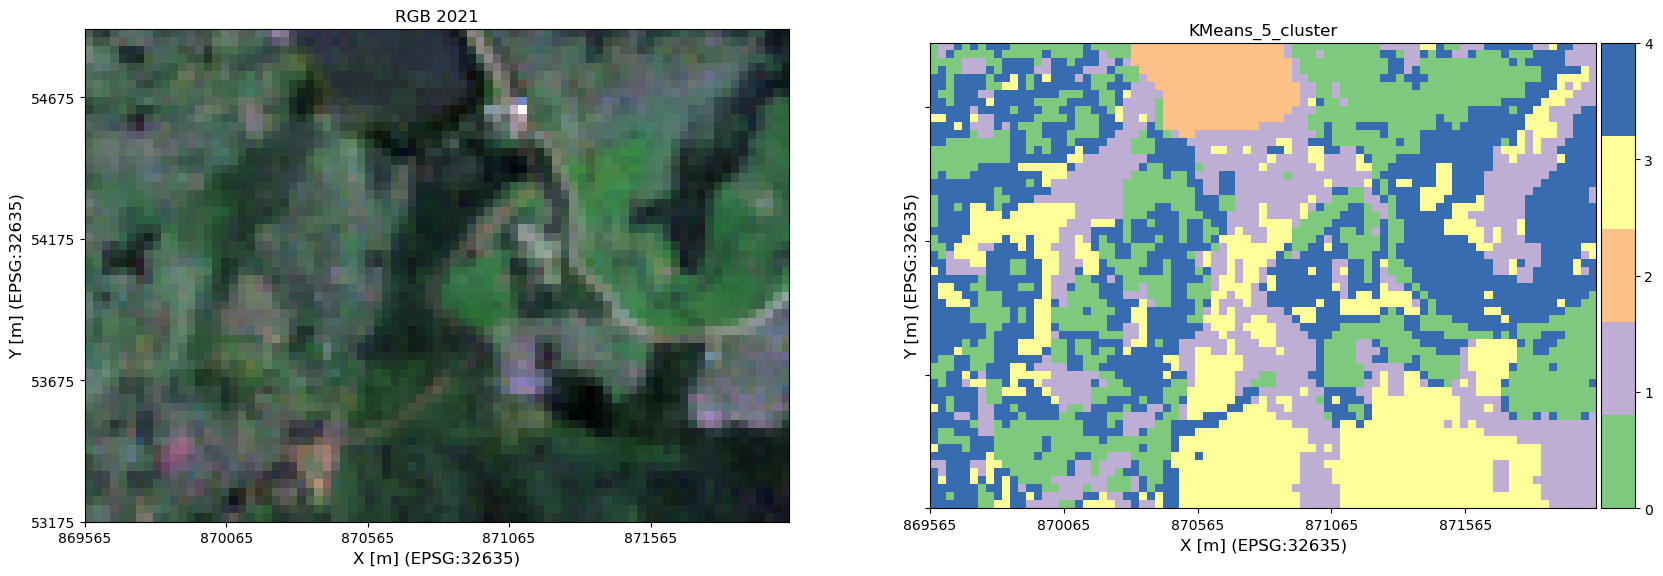

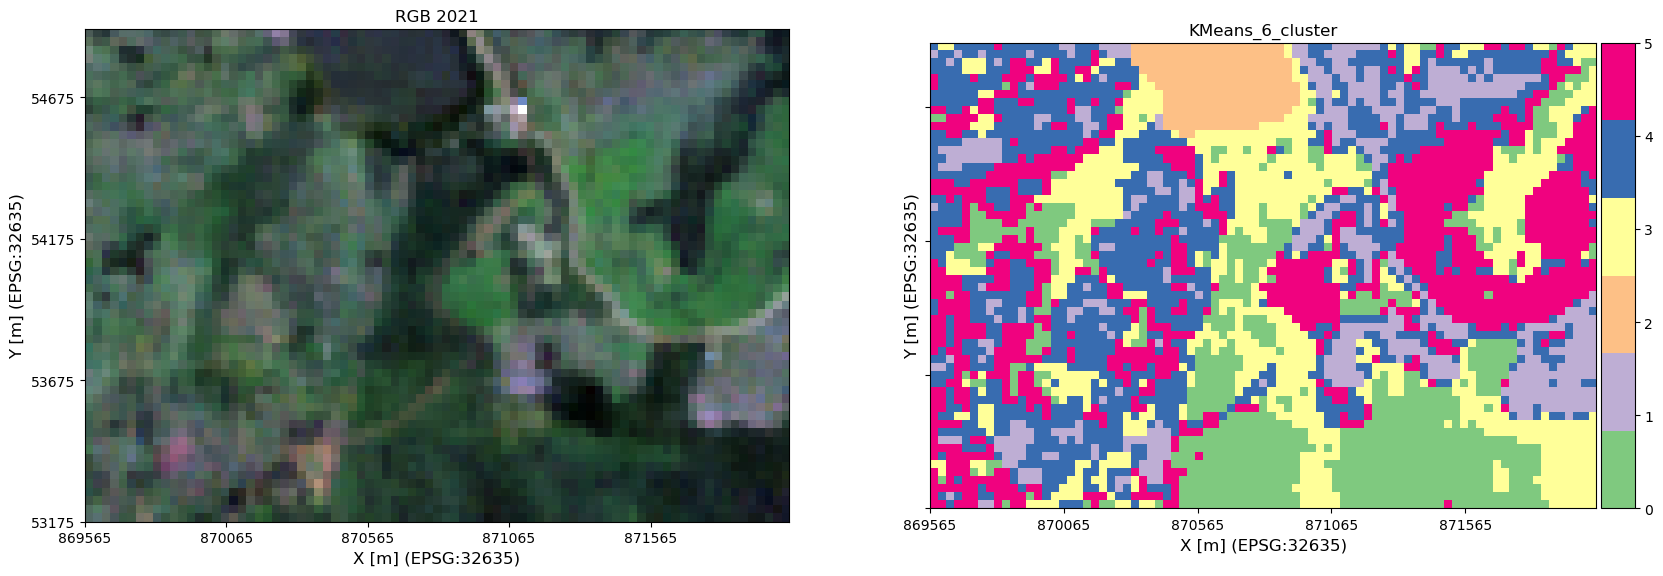

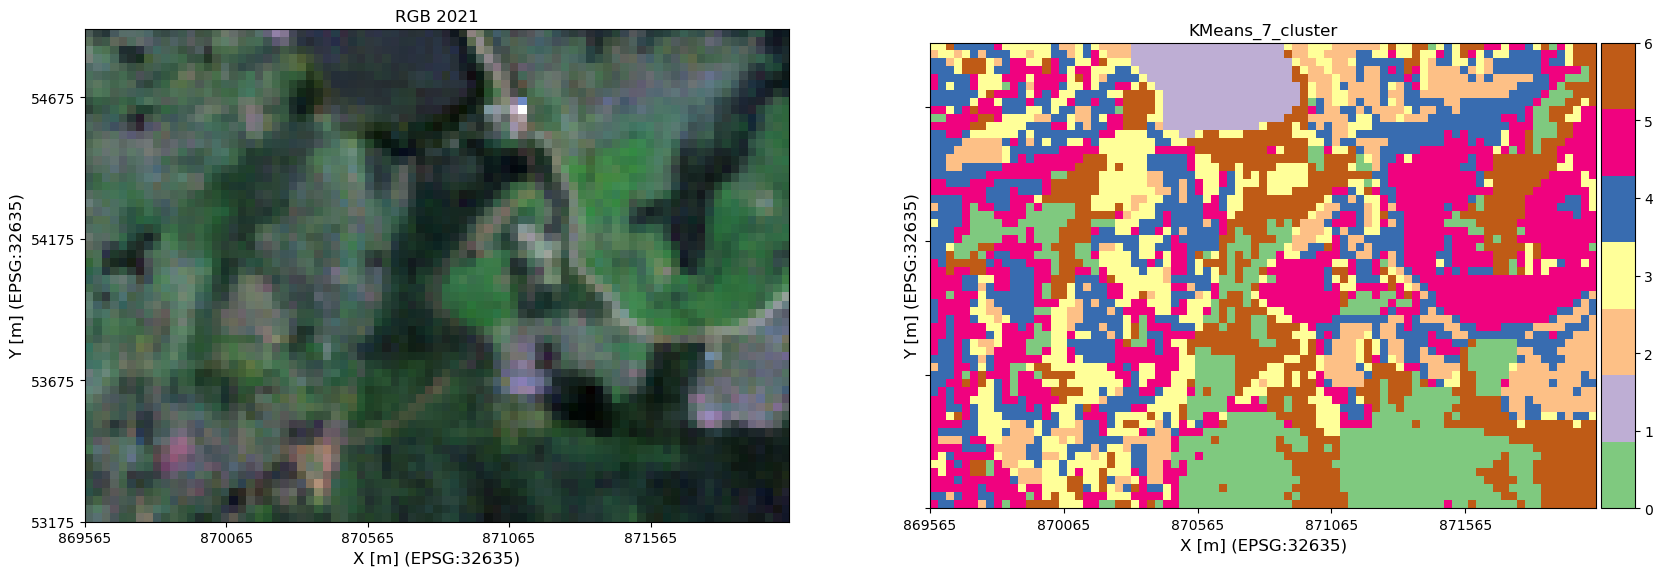

In [54]:
## Use K-means for Clustering:

# set the desired number of clusters for KMean and GMM

for n in range(3, 8, 1):

    # create model
    km = KMeans(n_clusters = n, n_init = 'auto') 

    # fit the model to the data
    km.fit(scaled_features)

    # Get the cluster labels
    labels = km.labels_

    # Calculate the scores
    silhouette = silhouette_score(scaled_features, labels)
    calinski_harabasz = calinski_harabasz_score(scaled_features, labels)
    davies_bouldin = davies_bouldin_score(scaled_features, labels)

    # Print the scores
    print(f'kmeans, {n}, Silhouette score, {silhouette}')
    print(f'kmeans, {n}, Calinski-Harabasz score, {calinski_harabasz}')
    print(f'kmeans, {n}, Davies-Bouldin score, {davies_bouldin}')

    # Add the cluster labels to the DataFrame and show it
    gdf[f'KMeans_{n}_cluster'] = labels
        
    # create new band instance from a column in GeoDataFrame
    KMeans_cluster = Band.from_vector(vector_features = gdf,
                                 band_name_src = f'KMeans_{n}_cluster',
                                 geo_info = composite['blue'].geo_info,
                                 band_name_dst = f'KMeans_{n}_cluster'
                                 )

    #add column KMeans_cluster as a new Band into the RasterCollection composite
    composite.add_band(KMeans_cluster)
    
    #plot clusters
    fig, axs = plt.subplots(1, 2, figsize = (20, 10), sharey=True)
    cmap = plt.cm.colors.ListedColormap(colors[:n])
    ticks = list(range(n))

    composite.plot_multiple_bands(["red", "green", "blue"], ax=axs[0])
    axs[0].set_title(f'RGB {year}')

    composite.plot_band(f'KMeans_{n}_cluster', colormap=cmap, discrete_values = False, user_defined_ticks = ticks, ax=axs[1])
    axs[1].set_title(f'KMeans_{n}_cluster')
    
    #save as PNG for quick view
    fig.savefig(f'S:\MSc_23_TimckeFinn\data\python_outputs\cluster\KMeans_{n}_cluster_{year}.png')


c:\Users\ftimcke\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=19.
  warnings.warn(


gmm, 3, Silhouette score, 0.3214744905934533
gmm, 3, Calinski-Harabasz score, 5627.070201127128
gmm, 3, Davies-Bouldin score, 0.8828659142275785


c:\Users\ftimcke\AppData\Local\anaconda3\lib\site-packages\eodal\core\band.py:1637: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.set_ticklabels(user_defined_ticks)
c:\Users\ftimcke\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=19.
  warnings.warn(


gmm, 4, Silhouette score, 0.3214744905934533
gmm, 4, Calinski-Harabasz score, 5627.070201127128
gmm, 4, Davies-Bouldin score, 0.8828659142275785


c:\Users\ftimcke\AppData\Local\anaconda3\lib\site-packages\eodal\core\band.py:1637: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.set_ticklabels(user_defined_ticks)
c:\Users\ftimcke\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=19.
  warnings.warn(


gmm, 5, Silhouette score, 0.3214744905934533
gmm, 5, Calinski-Harabasz score, 5627.070201127128
gmm, 5, Davies-Bouldin score, 0.8828659142275785


c:\Users\ftimcke\AppData\Local\anaconda3\lib\site-packages\eodal\core\band.py:1637: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.set_ticklabels(user_defined_ticks)
c:\Users\ftimcke\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=19.
  warnings.warn(


gmm, 6, Silhouette score, 0.3214744905934533
gmm, 6, Calinski-Harabasz score, 5627.070201127128
gmm, 6, Davies-Bouldin score, 0.8828659142275785


c:\Users\ftimcke\AppData\Local\anaconda3\lib\site-packages\eodal\core\band.py:1637: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.set_ticklabels(user_defined_ticks)
c:\Users\ftimcke\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=19.
  warnings.warn(


gmm, 7, Silhouette score, 0.3214744905934533
gmm, 7, Calinski-Harabasz score, 5627.070201127128
gmm, 7, Davies-Bouldin score, 0.8828659142275785


c:\Users\ftimcke\AppData\Local\anaconda3\lib\site-packages\eodal\core\band.py:1637: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.set_ticklabels(user_defined_ticks)


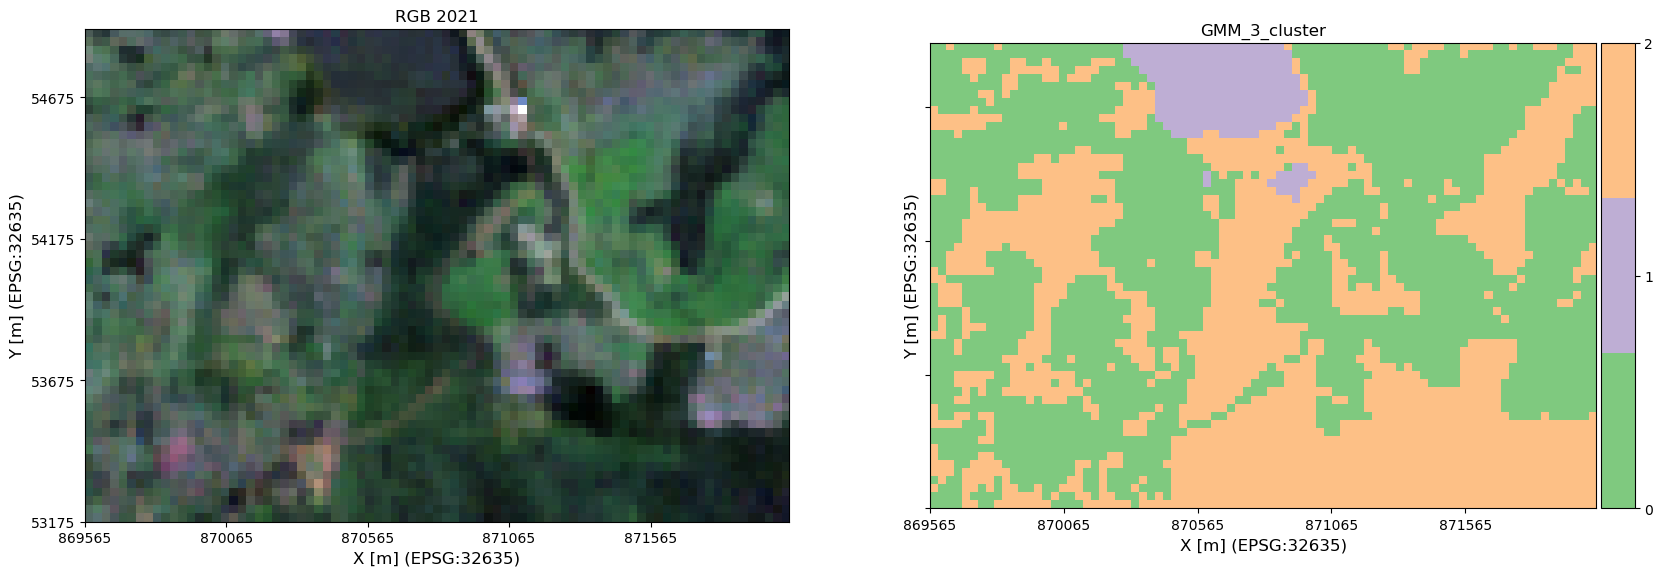

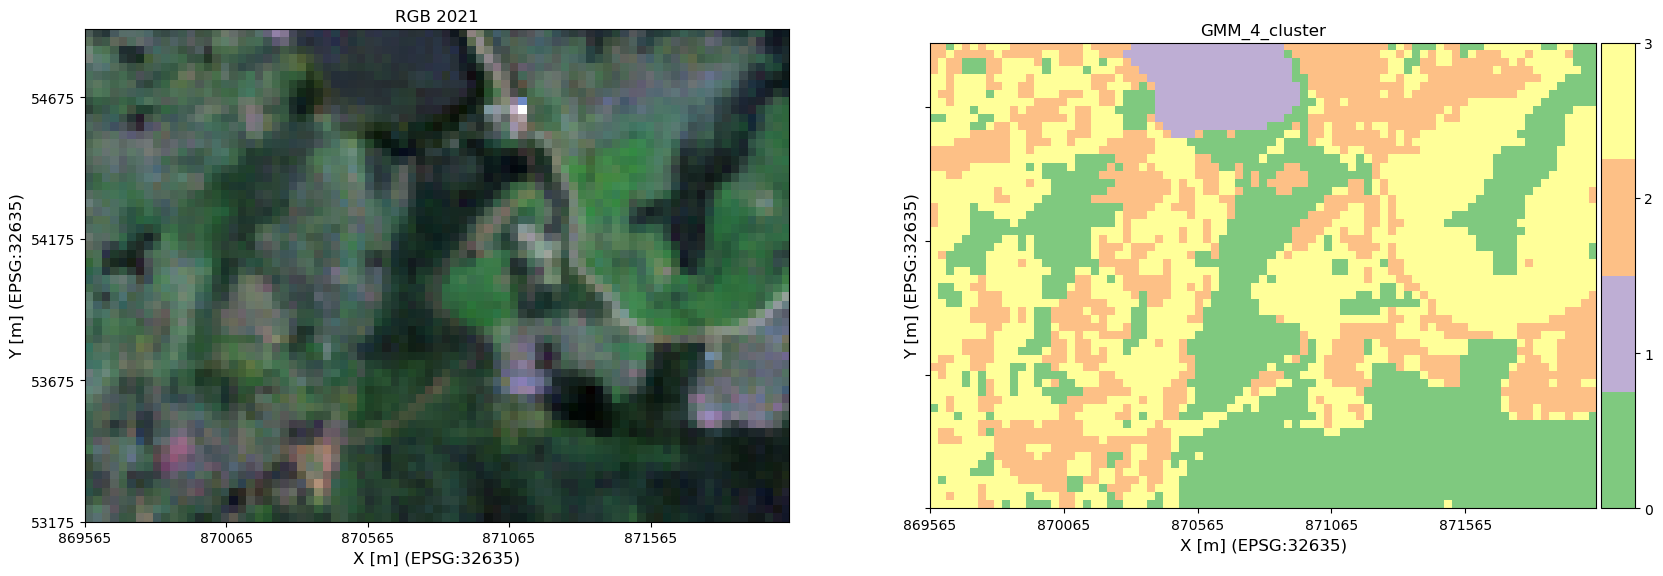

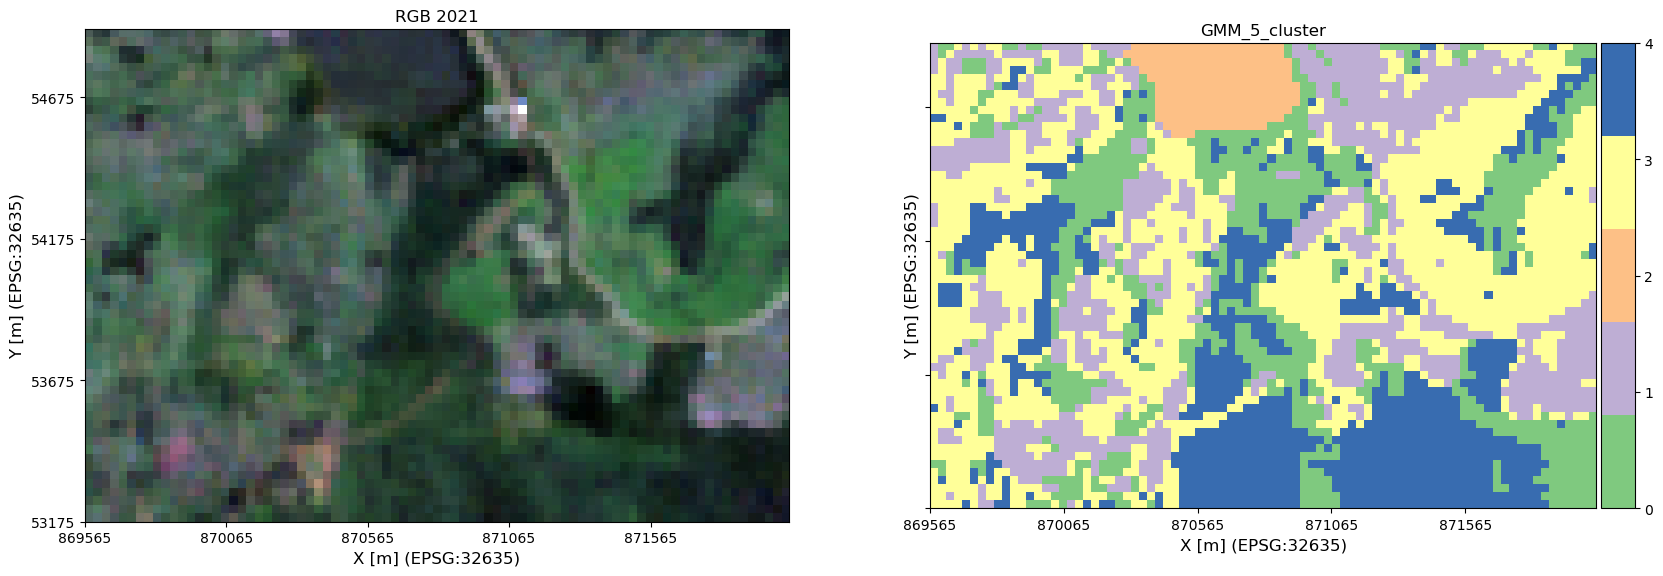

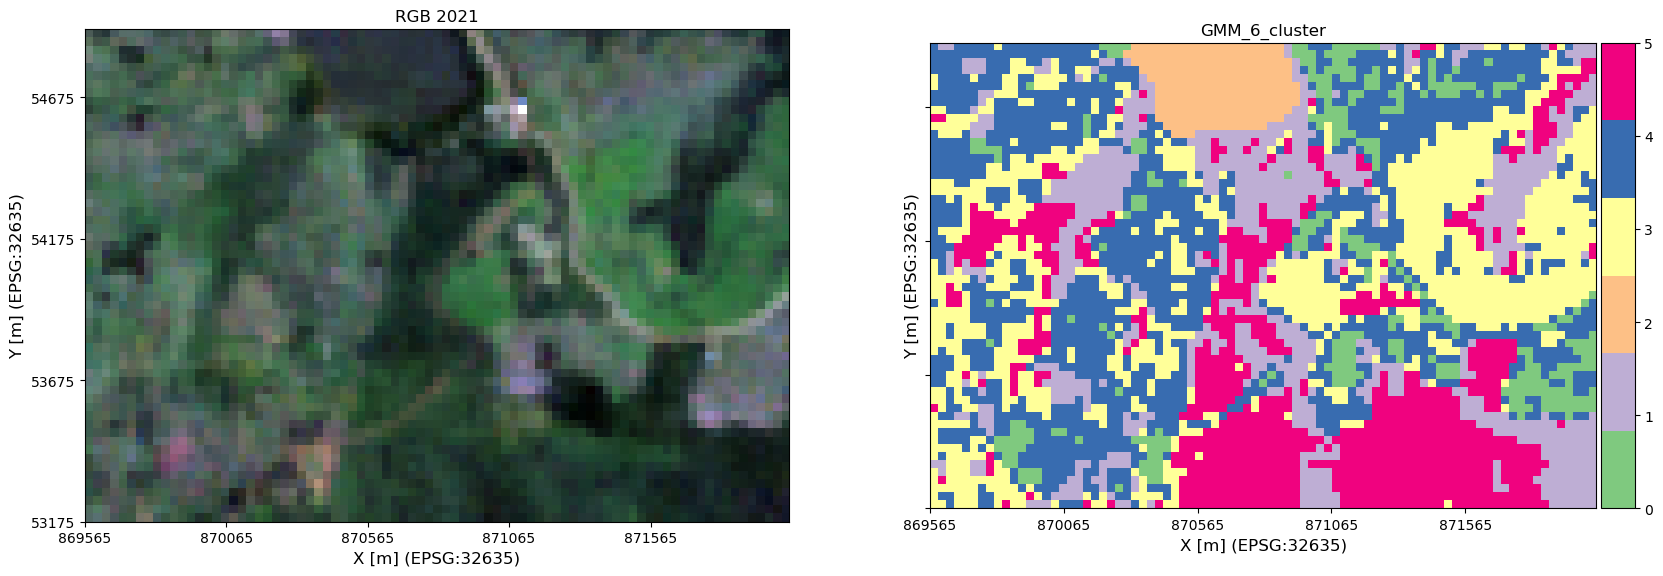

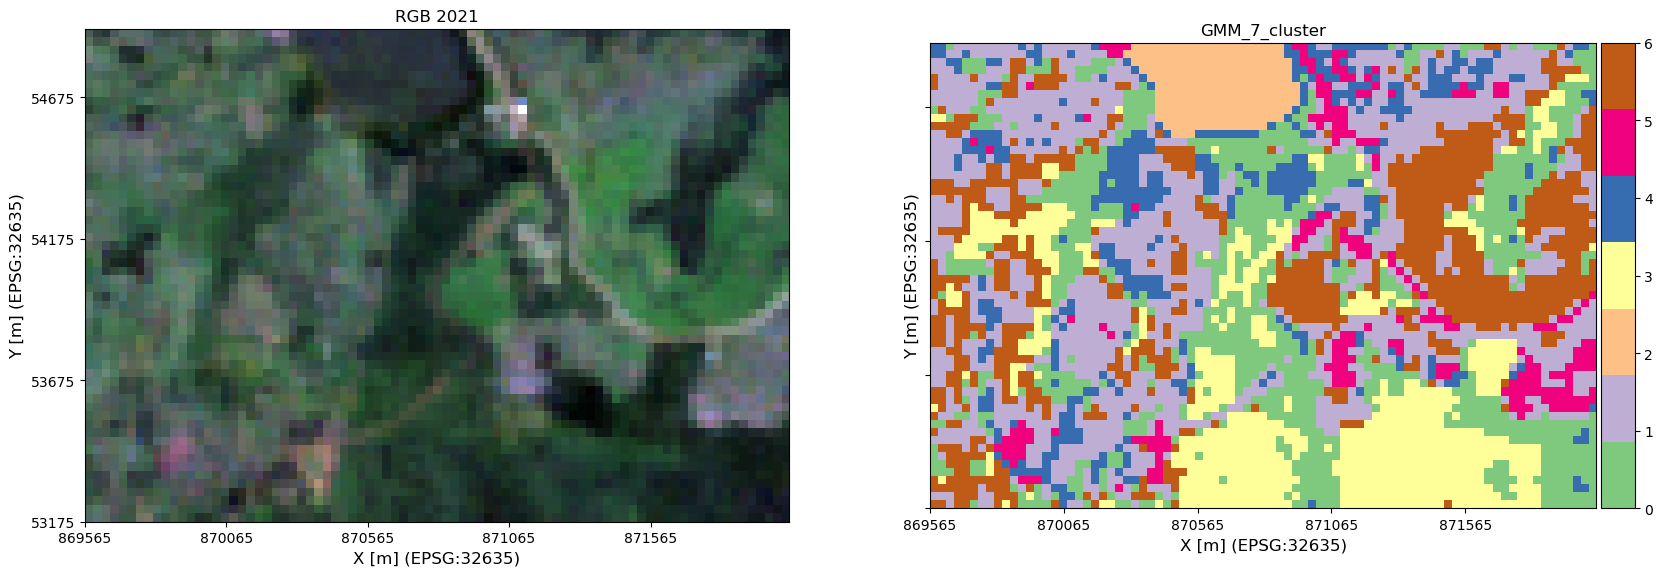

In [55]:
## Use Gaussian Mixture Models for Clustering:

for n in range(3, 8, 1):

    # create model
    gmm = GaussianMixture(n_components = n)

    # fit the model to the data
    gmm.fit(scaled_features)

    # Assign cluster labels
    GMM_cluster = gmm.predict(scaled_features)

    # Calculate the scores
    silhouette = silhouette_score(scaled_features, labels)
    calinski_harabasz = calinski_harabasz_score(scaled_features, labels)
    davies_bouldin = davies_bouldin_score(scaled_features, labels)

    # Print the scores
    print(f'gmm, {n}, Silhouette score, {silhouette}')
    print(f'gmm, {n}, Calinski-Harabasz score, {calinski_harabasz}')
    print(f'gmm, {n}, Davies-Bouldin score, {davies_bouldin}')

    # Assign cluster labels to GeoDataFrame
    gdf[f'GMM_{n}_cluster'] = GMM_cluster

    # create new band instance from a column in GeoDataFrame
    GMM_cluster = Band.from_vector(vector_features = gdf,
                                    band_name_src = f'GMM_{n}_cluster',
                                    geo_info = composite['blue'].geo_info,
                                    band_name_dst = f'GMM_{n}_cluster')

    #add column GMM_cluster as a new Band into the RasterCollection composite
    composite.add_band(GMM_cluster)
    
    #plot clusters
    fig, axs = plt.subplots(1, 2, figsize = (20, 10), sharey=True)
    cmap = plt.cm.colors.ListedColormap(colors[:n])
    ticks = list(range(n))

    composite.plot_multiple_bands(["red", "green", "blue"], ax=axs[0])
    axs[0].set_title(f'RGB {year}')

    composite.plot_band(f'GMM_{n}_cluster', colormap=cmap, discrete_values = False, user_defined_ticks = ticks, ax=axs[1])
    axs[1].set_title(f'GMM_{n}_cluster')
    
    #save as PNG for quick view
    fig.savefig(f'S:\MSc_23_TimckeFinn\data\python_outputs\cluster\GMM_{n}_cluster_{year}.png')

estimated bandwidth: 0.4


c:\Users\ftimcke\AppData\Local\anaconda3\lib\site-packages\eodal\core\band.py:1637: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.set_ticklabels(user_defined_ticks)


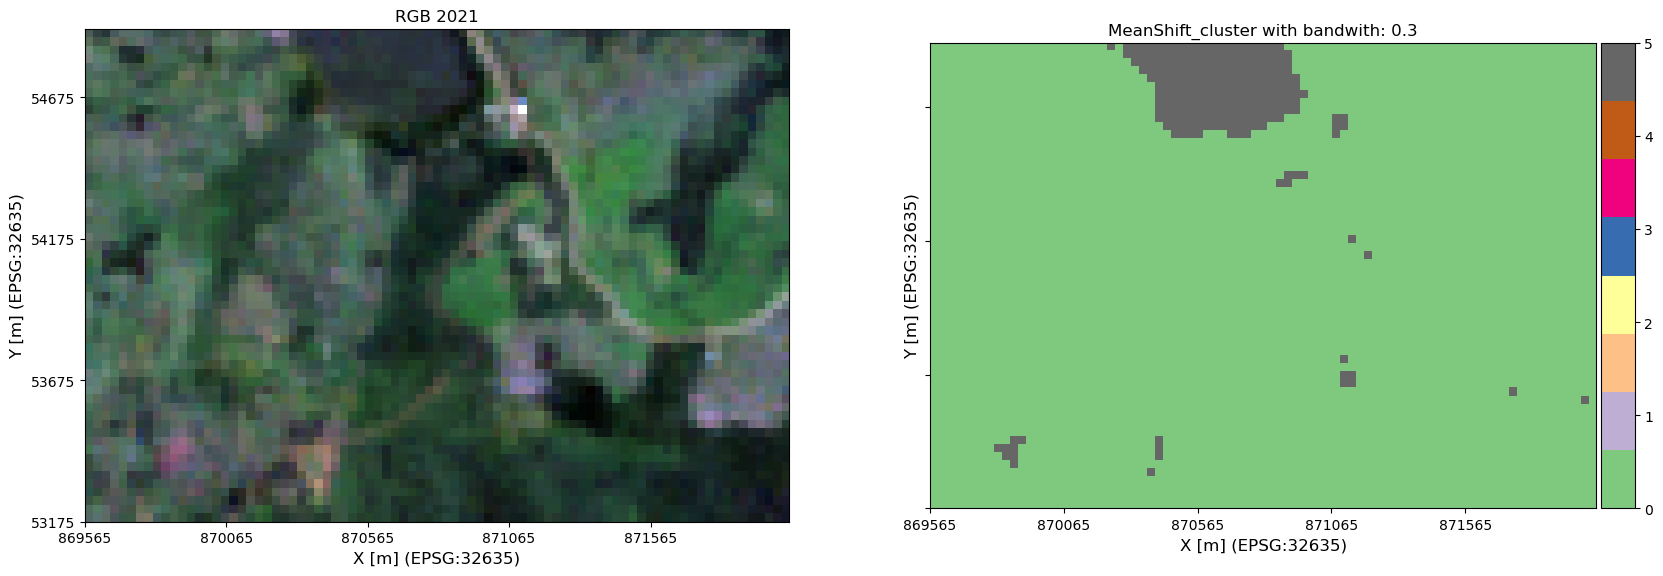

In [65]:
## Use MeanShift for Clustering:
from sklearn.cluster import estimate_bandwidth

bandwidth_est = estimate_bandwidth(scaled_features)
print(f'estimated bandwidth: {bandwidth_est}')

#define bandwidth for model
bandwidth = 0.3

# create model
ms = MeanShift(bandwidth=bandwidth)

# fit the model to the data
ms.fit(scaled_features)

# Assign cluster labels
cluster_labels = ms.labels_

# Assign cluster labels to GeoDataFrame
gdf[f'MeanShift_cluster_{bandwidth}'] = cluster_labels

# add column cluster_mean_shift as a new Band into the RasterCollection composite
MeanShift_cluster = Band.from_vector(vector_features = gdf,
                                band_name_src = f'MeanShift_cluster_{bandwidth}',
                                geo_info = composite['blue'].geo_info,
                                band_name_dst=f'MeanShift_cluster_{bandwidth}')

composite.add_band(MeanShift_cluster)

#plot clusters
fig, axs = plt.subplots(1, 2, figsize = (20, 10), sharey=True)

composite.plot_multiple_bands(["red", "green", "blue"], ax=axs[0])
axs[0].set_title(f'RGB {year}')

composite.plot_band(f'MeanShift_cluster_{bandwidth}', colormap='Accent', discrete_values = False, user_defined_ticks = ticks, ax=axs[1])
axs[1].set_title(f'MeanShift_cluster with bandwith: {bandwidth}')

#save as PNG for quick view
fig.savefig(f'S:\MSc_23_TimckeFinn\data\python_outputs\cluster\MS_cluster_{year}_{bandwidth}.png')


In [58]:
# save as GeoTiff
composite.to_rasterio(f'S:\MSc_23_TimckeFinn\data\EOdal\landsat_median_composite_cluster_{year}.tif')